In [1]:
from keras.models import *
from losses import *
import matplotlib.pyplot as plt
%matplotlib inline

/home/bodong/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# from models.dla import DLA
# from models.centernet import centernet, DLA_seg

from models.resnet import centernet
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras.utils import multi_gpu_model

In [3]:
import keras.backend as K
import tensorflow as tf
## gpu option
K.clear_session()

num_of_gpu = len(os.environ["CUDA_VISIBLE_DEVICES"].split(','))
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# K.set_session(sess)

In [4]:
shape = (512,512,3)
num_classes = 20
cat_spec_wh = False
return_model_only = True
# dla_model = DLA(shape,return_levels=True)
# model, pred_model,debug_model = centernet(shape, dla_model, 20)
# pred_model.predict(np.random.random((1,512,512,3)))
# pred_model.summary()
if num_of_gpu <= 1:
    model, prediction_model, debug_model = centernet(num_classes=num_classes, input_size=shape[0],
                                                         freeze_bn=False,cat_spec_wh=cat_spec_wh)
else:
    with tf.device("/cpu:0"):
        model_ = centernet(num_classes=num_classes, input_size=shape[0],
                                                         freeze_bn=False,cat_spec_wh=cat_spec_wh,return_model_only=return_model_only)
    model = multi_gpu_model(model_, gpus=num_of_gpu)
#     prediction_model = prediction_model_

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[(None, 128, 128, 20), (None, 128, 128, 2), (None, 128, 128, 2), (None, 128, 128, 20), (None, 100, 2), (None, 100), (None, 100, 2), (None, 100), (None, 100)]


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 256, 256, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
pool1 (Max

In [6]:
model.load_weights('haha.hdf5')

In [6]:
from augmentor.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from augmentor.object_detection_2d_geometric_ops import Resize
from augmentor.object_detection_2d_patch_sampling_ops import RandomPadFixedAR
from augmentor.object_detection_2d_photometric_ops import ConvertTo3Channels
data_augmentation_chain = DataAugmentationVariableInputSize(512,
                                                            512,
                                                            random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            n_trials_max=3,
                                                            min_scale=0.6,
                                                            max_scale=1.5,
                                                            min_aspect_ratio = 0.8,
                                                            max_aspect_ratio = 1.2,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

convert_to_3_channels = ConvertTo3Channels()
pad = RandomPadFixedAR(1.0)
resize = Resize(height=512, width=512)
data_augmentation_chain2 = [convert_to_3_channels,
                          pad,
                          resize]

In [26]:


def create_generators(pascal_path=None,random_transform=True,dataset_type='pascal',multi_scale=False,cat_spec_wh=False):
    """
    Create generators for training and validation.

    Args
        args: parseargs object containing configuration for generators.
        preprocess_image: Function that preprocesses an image for the network.
    """
    common_args = {
        'batch_size': 24,
        'input_size': 512,
        'cat_spec_wh':cat_spec_wh,
    }
    coco_path = '/opt/train_data/COCO_data/'
    pascal_path ='/opt/train_data/VOC_data/VOCdevkit/VOC0712/'

    if dataset_type == 'pascal':
        from generators_bodong.pascal import PascalVocGenerator
        train_generator = PascalVocGenerator(
            pascal_path,
            'trainval',
            skip_difficult=True,
            transformations=[data_augmentation_chain],
            **common_args
        )

        validation_generator = PascalVocGenerator(
            pascal_path,
            'test',
            skip_difficult=True,
            shuffle_groups=False,
            transformations=data_augmentation_chain2,
            **common_args
        )
    elif dataset_type == 'csv':
        from generators_bodong.csv_ import CSVGenerator
        train_generator = CSVGenerator(
            args.annotations_path,
            args.classes_path,
            transformations=[data_augmentation_chain],
            **common_args
        )

        if args.val_annotations_path:
            validation_generator = CSVGenerator(
                args.val_annotations_path,
                args.classes_path,
                shuffle_groups=False,
                transformations=data_augmentation_chain2,
                **common_args
            )
        else:
            validation_generator = None
    elif dataset_type == 'coco':
        from generators_bodong.coco import CocoGenerator

        train_generator = CocoGenerator(
            coco_path,
            'train2017',
            transformations=[data_augmentation_chain],
            **common_args
        )

        validation_generator = CocoGenerator(
            coco_path,
            'val2017',
            shuffle_groups=False,
            transformations=data_augmentation_chain2,
            **common_args
        )
    else:
        raise ValueError('Invalid data type received: {}'.format(args.dataset_type))

    return train_generator, validation_generator

In [27]:
train_generator, validation_generator = create_generators(dataset_type='pascal')

[192.0, 194.0, 432.0, 294.0]
3 boat
[84.0, 205.0, 244.0, 283.0]
3 boat
[63.0, 55.0, 161.0, 161.0]
3 boat
[272.0, 324.0, 496.0, 380.0]
3 boat
[67.0, 354.0, 381.0, 398.0]
3 boat
[68.0, 324.0, 180.0, 380.0]
3 boat
[263.0, 162.0, 305.0, 214.0]
14 person
[101.0, 315.0, 275.0, 365.0]
3 boat


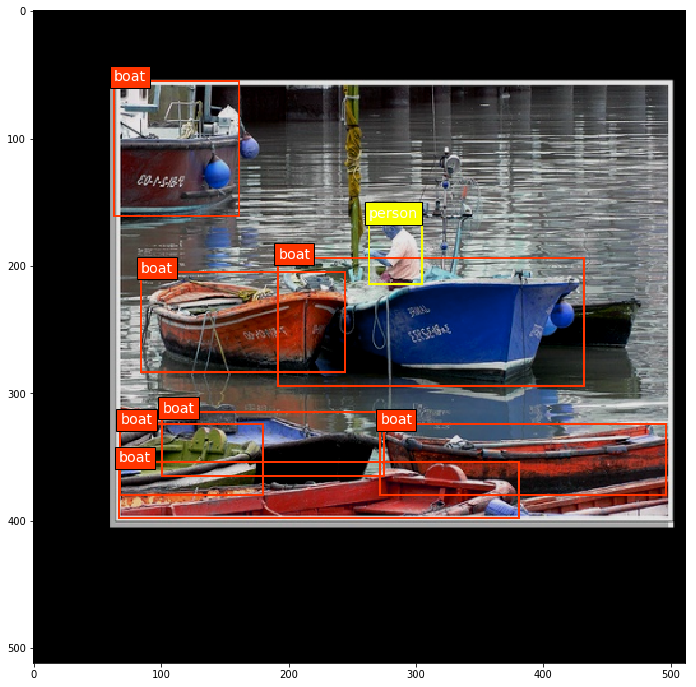

In [28]:
# visualize
data = train_generator.__getitem__(0)
inp, hm_input, wh_input,wh_mask_input, reg_input, reg_mask_input, index_input = data[0]
k = 0
plt.figure(figsize=(20,12))
plt.imshow(inp[k]+0.5)
colors = plt.cm.hsv(np.linspace(0, 1, 80+1)).tolist() # Set the colors for the bounding boxes
classes = train_generator.labels
current_axis = plt.gca()
# # Draw the ground truth boxes in green (omit the label for more clarity)
# for box in batch_labels[i]:
#     xmin = box[1]
#     ymin = box[2]
#     xmax = box[3]
#     ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
#     #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
cls = np.reshape(np.argmax(hm_input[k], axis=-1),(-1,)).tolist()
for k1 in range(0,100):
    if reg_mask_input[k][k1] == 0:
        break
    idx = int(index_input[k][k1])
    y_, x_ = idx//128*4, idx%128*4
    w,h = wh_input[k][k1]*4
    box = [x_-w//2,y_-h//2,x_+w//2,y_+h//2]
    print box
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(cls[idx])]
    print int(cls[idx]),classes[int(cls[idx])]
    label = '{}'.format(classes[int(cls[idx])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [29]:
from keras.callbacks import *
def create_callbacks(training_model, prediction_model, validation_generator, snapshot_path,
                     evaluation=True,dataset_type='voc',snapshots=True):
    """
    Creates the callbacks to use during training.

    Args
        training_model: The model that is used for training.
        prediction_model: The model that should be used for validation.
        validation_generator: The generator for creating validation data.
        args: parseargs args object.

    Returns:
        A list of callbacks used for training.
    """
    callbacks = []


    if evaluation and validation_generator:
        if dataset_type == 'coco':
            from eval.coco import CocoEval
            # use prediction model for evaluation
            evaluation = CocoEval(validation_generator, prediction_model)
        else:
            from eval.pascal import Evaluate
            evaluation = Evaluate(validation_generator, prediction_model)
        callbacks.append(evaluation)

    # save the model
    if snapshots:
        # ensure directory created first; otherwise h5py will error after epoch.
        if not os.path.exists(snapshot_path):
            os.makedirs(snapshot_path)
        checkpoint = ModelCheckpoint(
            os.path.join(
                snapshot_path,
                '{dataset_type}_{{epoch:02d}}_{{loss:.4f}}_{{val_loss:.4f}}.h5'.format(dataset_type=dataset_type)
            ),
            verbose=1,
            save_best_only=True,
            # monitor="mAP",
            # mode='max'
        )
        callbacks.append(checkpoint)

    # callbacks.append(keras.callbacks.ReduceLROnPlateau(
    #     monitor='loss',
    #     factor=0.1,
    #     patience=2,
    #     verbose=1,
    #     mode='auto',
    #     min_delta=0.0001,
    #     cooldown=0,
    #     min_lr=0
    # ))

    return callbacks

In [35]:
from keras.optimizers import Adam, SGD
model.compile(optimizer=Adam(lr=1e-5), loss={'centernet_loss': lambda y_true, y_pred: y_pred})
# model.compile(optimizer=SGD(lr=1e-5), loss={'centernet_loss': lambda y_true, y_pred: y_pred})

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 256, 256, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
pool1 (Max

In [30]:
from datetime import datetime
log_dir_base = './ckpt/res18_voc/'
subdir = datetime.strftime(datetime.now(), '%Y%m%d')
log_dir = os.path.join(log_dir_base, subdir)

callbacks = create_callbacks(
       model,
       prediction_model,
       validation_generator,
       log_dir,
       dataset_type='pascal'
    )

In [ ]:
model.fit_generator(
        generator=train_generator,
        steps_per_epoch=10000,
        initial_epoch=27,
        epochs=500,
        verbose=1,
        callbacks=callbacks,
        workers=3,
        use_multiprocessing=True,
        validation_data=validation_generator
    )

Epoch 28/500
10000/10000 [==============================] - 5080s 508ms/step - loss: 1.5011 - val_loss: 3.0877


Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:36 Time:  0:02:36
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6694')
('337 instances of class', 'bicycle', 'with average precision: 0.7370')
('459 instances of class', 'bird', 'with average precision: 0.5083')
('263 instances of class', 'boat', 'with average precision: 0.5072')
('469 instances of class', 'bottle', 'with average precision: 0.3783')
('213 instances of class', 'bus', 'with average precision: 0.7191')
('1201 instances of class', 'car', 'with average precision: 0.7989')
('358 instances of class', 'cat', 'with average precision: 0.6893')
('756 instances of class', 'chair', 'with average precision: 0.4064')
('244 instances of class', 'cow', 'with average precision: 0.6426')
('206 instances of class', 'diningtable', 'with average precision: 0.5444')
('489 instances of class', 'dog', 'with average precision: 0.6672')
('348 instances of class', 'horse', 'with average precision: 0.7725')
('325 instances of class', 'motorbike', 'with average precision: 0.7653')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:35 Time:  0:02:35
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:03 Time:  0:00:03


('285 instances of class', 'aeroplane', 'with average precision: 0.6780')
('337 instances of class', 'bicycle', 'with average precision: 0.7408')
('459 instances of class', 'bird', 'with average precision: 0.5142')
('263 instances of class', 'boat', 'with average precision: 0.5086')
('469 instances of class', 'bottle', 'with average precision: 0.3842')
('213 instances of class', 'bus', 'with average precision: 0.7281')
('1201 instances of class', 'car', 'with average precision: 0.7935')
('358 instances of class', 'cat', 'with average precision: 0.6939')
('756 instances of class', 'chair', 'with average precision: 0.4109')
('244 instances of class', 'cow', 'with average precision: 0.6325')
('206 instances of class', 'diningtable', 'with average precision: 0.5619')
('489 instances of class', 'dog', 'with average precision: 0.6623')
('348 instances of class', 'horse', 'with average precision: 0.7854')
('325 instances of class', 'motorbike', 'with average precision: 0.7668')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:35 Time:  0:02:35
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6754')
('337 instances of class', 'bicycle', 'with average precision: 0.7421')
('459 instances of class', 'bird', 'with average precision: 0.5230')
('263 instances of class', 'boat', 'with average precision: 0.5036')
('469 instances of class', 'bottle', 'with average precision: 0.3784')
('213 instances of class', 'bus', 'with average precision: 0.7215')
('1201 instances of class', 'car', 'with average precision: 0.7931')
('358 instances of class', 'cat', 'with average precision: 0.6964')
('756 instances of class', 'chair', 'with average precision: 0.4102')
('244 instances of class', 'cow', 'with average precision: 0.6296')
('206 instances of class', 'diningtable', 'with average precision: 0.5695')
('489 instances of class', 'dog', 'with average precision: 0.6639')
('348 instances of class', 'horse', 'with average precision: 0.7834')
('325 instances of class', 'motorbike', 'with average precision: 0.7680')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:35 Time:  0:02:35
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6785')
('337 instances of class', 'bicycle', 'with average precision: 0.7472')
('459 instances of class', 'bird', 'with average precision: 0.5196')
('263 instances of class', 'boat', 'with average precision: 0.5018')
('469 instances of class', 'bottle', 'with average precision: 0.3768')
('213 instances of class', 'bus', 'with average precision: 0.7265')
('1201 instances of class', 'car', 'with average precision: 0.7941')
('358 instances of class', 'cat', 'with average precision: 0.6986')
('756 instances of class', 'chair', 'with average precision: 0.4152')
('244 instances of class', 'cow', 'with average precision: 0.6347')
('206 instances of class', 'diningtable', 'with average precision: 0.5508')
('489 instances of class', 'dog', 'with average precision: 0.6633')
('348 instances of class', 'horse', 'with average precision: 0.7704')
('325 instances of class', 'motorbike', 'with average precision: 0.7609')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:35 Time:  0:02:35
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6798')
('337 instances of class', 'bicycle', 'with average precision: 0.7407')
('459 instances of class', 'bird', 'with average precision: 0.5198')
('263 instances of class', 'boat', 'with average precision: 0.5078')
('469 instances of class', 'bottle', 'with average precision: 0.3802')
('213 instances of class', 'bus', 'with average precision: 0.7267')
('1201 instances of class', 'car', 'with average precision: 0.7960')
('358 instances of class', 'cat', 'with average precision: 0.6901')
('756 instances of class', 'chair', 'with average precision: 0.4127')
('244 instances of class', 'cow', 'with average precision: 0.6373')
('206 instances of class', 'diningtable', 'with average precision: 0.5608')
('489 instances of class', 'dog', 'with average precision: 0.6677')
('348 instances of class', 'horse', 'with average precision: 0.7769')
('325 instances of class', 'motorbike', 'with average precision: 0.7619')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:35 Time:  0:02:35
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6711')
('337 instances of class', 'bicycle', 'with average precision: 0.7480')
('459 instances of class', 'bird', 'with average precision: 0.5183')
('263 instances of class', 'boat', 'with average precision: 0.5066')
('469 instances of class', 'bottle', 'with average precision: 0.3755')
('213 instances of class', 'bus', 'with average precision: 0.7211')
('1201 instances of class', 'car', 'with average precision: 0.7948')
('358 instances of class', 'cat', 'with average precision: 0.6971')
('756 instances of class', 'chair', 'with average precision: 0.4125')
('244 instances of class', 'cow', 'with average precision: 0.6334')
('206 instances of class', 'diningtable', 'with average precision: 0.5632')
('489 instances of class', 'dog', 'with average precision: 0.6690')
('348 instances of class', 'horse', 'with average precision: 0.7723')
('325 instances of class', 'motorbike', 'with average precision: 0.7613')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:34 Time:  0:02:34
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6689')
('337 instances of class', 'bicycle', 'with average precision: 0.7499')
('459 instances of class', 'bird', 'with average precision: 0.5286')
('263 instances of class', 'boat', 'with average precision: 0.5142')
('469 instances of class', 'bottle', 'with average precision: 0.3816')
('213 instances of class', 'bus', 'with average precision: 0.7253')
('1201 instances of class', 'car', 'with average precision: 0.8005')
('358 instances of class', 'cat', 'with average precision: 0.6947')
('756 instances of class', 'chair', 'with average precision: 0.4094')
('244 instances of class', 'cow', 'with average precision: 0.6346')
('206 instances of class', 'diningtable', 'with average precision: 0.5607')
('489 instances of class', 'dog', 'with average precision: 0.6809')
('348 instances of class', 'horse', 'with average precision: 0.7783')
('325 instances of class', 'motorbike', 'with average precision: 0.7617')
('4528 instanc

Running network: 100% (4952 of 4952) |###| Elapsed Time: 0:02:40 Time:  0:02:40
Parsing annotations: 100% (4952 of 4952) || Elapsed Time: 0:00:02 Time:  0:00:02


('285 instances of class', 'aeroplane', 'with average precision: 0.6748')
('337 instances of class', 'bicycle', 'with average precision: 0.7484')
('459 instances of class', 'bird', 'with average precision: 0.5275')
('263 instances of class', 'boat', 'with average precision: 0.5061')
('469 instances of class', 'bottle', 'with average precision: 0.3792')
('213 instances of class', 'bus', 'with average precision: 0.7252')
('1201 instances of class', 'car', 'with average precision: 0.7951')
('358 instances of class', 'cat', 'with average precision: 0.7040')
('756 instances of class', 'chair', 'with average precision: 0.4046')
('244 instances of class', 'cow', 'with average precision: 0.6278')
('206 instances of class', 'diningtable', 'with average precision: 0.5673')
('489 instances of class', 'dog', 'with average precision: 0.6721')
('348 instances of class', 'horse', 'with average precision: 0.7684')
('325 instances of class', 'motorbike', 'with average precision: 0.7691')
('4528 instanc

In [27]:
model.save('./haha.hdf5')

In [15]:
data = train_generator.__getitem__(0)
inp, hm_input, wh_input,wh_mask_input, reg_input, reg_mask_input, index_input = data[0]

In [16]:
loss = model.predict_on_batch(data[0])

In [ ]:
res = prediction_model.predict(inp[:1])

In [ ]:
hm, wh, reg = debug_model.predict(inp[:1])

In [23]:
hm.shape

(1, 128, 128, 80)

In [24]:
postprocess_(hm, wh,reg,num_classes=num_classes)

NameError: name 'postprocess_' is not defined

In [25]:
res

array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0

In [23]:
validation_generator.label_to_name(22)

u'backpack'

In [31]:
k =0

In [32]:
reg_mask_input[k]

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [33]:
wh_input[k]

array([[17.986   , 19.896002],
       [ 9.5     , 26.598003],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [

In [ ]:
plt.imshow()

In [17]:
set(np.reshape(np.argmax(hm_input[k], axis=-1),(-1,)).tolist())

{0, 8}

In [34]:
index_input[k]

array([12969., 12748.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.], dtype=float32)

In [35]:
12969/128

101

In [36]:
hm_input[k].reshape((128*128,num_classes))[12969,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [39]:
validation_generator.label_to_name(14)

u'bird'

In [104]:
result = debug_model.predict(inp[k:k+1])

In [105]:
result[k]

IndexError: list index out of range

In [106]:
result[0].shape

(1, 128, 128, 20)

In [107]:
result[1].shape

(1, 128, 128, 2)

In [108]:
result[2].shape

(1, 128, 128, 2)

In [109]:
result[0][k][:,:,1].max()

IndexError: index 3 is out of bounds for axis 0 with size 1

In [110]:
result[1][k][63,65,:]

IndexError: index 3 is out of bounds for axis 0 with size 1

In [89]:
import numpy as np
def focal_loss(hm_pred, hm_true):
    pos_mask = hm_true==1
    neg_mask = hm_true<1
    neg_weights = np.power(1 - hm_true, 4)

    pos_loss = -np.log(np.clip(hm_pred, 1e-4, 1. - 1e-4)) * np.power(1 - hm_pred, 2) * pos_mask
    neg_loss = -np.log(np.clip(1 - hm_pred, 1e-4, 1. - 1e-4)) * np.power(hm_pred, 2) * neg_weights * neg_mask

    num_pos = np.sum(pos_mask)
    pos_loss = np.sum(pos_loss)
    neg_loss = np.sum(neg_loss)
    if num_pos > 0:
        
        cls_loss = (pos_loss + neg_loss) / num_pos
    else:
        cls_loss = neg_loss
    return cls_loss


def reg_l1_loss(y_pred, y_true, indices, mask):
    b, h, w, c = y_pred.shape
    k = indices.shape[1]
    y_pred = np.reshape(y_pred, (h*w, c))
    ii = np.tile(np.range(b)[:, np.newaxis], (1, k))
    idx = np.stack([ii, indices], axis=-1)
    y_pred = np.gather_nd(y_pred, idx)
    mask = np.tile(mask[..., np.newaxis], (1, 1, 2))
    total_loss = np.reduce_sum(np.abs(y_true * mask - y_pred * mask))
    reg_loss = total_loss / (np.sum(mask) + 1e-4)
    return reg_loss


def loss(args):
    hm_pred, wh_pred, reg_pred, hm_true, wh_true, reg_true, reg_mask, indices = args
    hm_loss = focal_loss(hm_pred, hm_true)
    wh_loss = 0.1 * reg_l1_loss(wh_pred, wh_true, indices, reg_mask)
    reg_loss = reg_l1_loss(reg_pred, reg_true, indices, reg_mask)
    total_loss = hm_loss + wh_loss + reg_loss
    return total_loss


In [90]:
focal_loss(result[0], hm_input[k:k+1])

31.119937896728516

In [111]:
hm_input[k].reshape((128*128,20))[8130,:]

array([0.      , 0.      , 0.992218, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      ], dtype=float32)

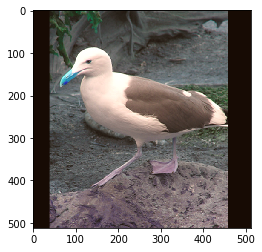

In [100]:
plt.imshow(inp[k]/256+0.5)


In [19]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def _pool2d(A, kernel_size, stride, padding, pool_mode='max'):
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(A, shape = output_shape + kernel_size,
                        strides = (stride*A.strides[0],
                                   stride*A.strides[1]) + A.strides)
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(1,2)).reshape(output_shape)
    elif pool_mode == 'avg':
        return A_w.mean(axis=(1,2)).reshape(output_shape)

def _nms(heat,hmax=None, kernel=3):
    # hmax = MaxPool2D(kernel, strides=1,padding='same')(heat)
    # heat = tf.where(tf.equal(hmax, heat), heat, tf.zeros_like(heat))
    if hmax is None:
        hmax = np.zeros_like(heat)
        b, h, w, c = heat.shape
        for batch in range(b):
            for channel in range(c):
                hmax[batch,:,:,channel] = _pool2d(heat[batch,:,:,channel], kernel_size=kernel, stride=1, padding=1)
    assert (heat.shape == hmax.shape)
    # make non local max item zero
    keep = heat==hmax
    # heat[heat!=hmax] = 0
    return heat*keep


def _topk(hm, hmax=None, max_objects=100):
    hm = _nms(hm,hmax)
    b, h, w, c = hm.shape
    # (b, h * w * c)
    hm = hm.reshape((b, -1))
    # (b, k), (b, k)
    # scores, indices = tf.nn.top_k(hm, k=max_objects)
    # scores2, indices2 = tf.nn.top_k(hm2, k=max_objects)
    # scores2 = tf.reshape(scores2, (b, -1))
    # topk = tf.nn.top_k(scores2, k=max_objects)
    # get first k largest score np.argsort return from small to large

    # (b, k)
    indices = np.argsort(-hm, axis=-1)[:,:max_objects]
    # (b, k)
    scores = np.zeros((b,max_objects))
    for batch in range(b):
        scores[batch,:] = hm[batch,indices[batch]]
    # all (b, k)
    class_ids = indices % c
    xs = indices // c % w
    ys = indices // c // w
    indices = ys * w + xs
    return scores, indices, class_ids, xs, ys
#
# def evaluate_batch_item(batch_item_detections, num_classes, max_objects_per_class=20, max_objects=100,
#                         iou_threshold=0.5, score_threshold=0.1):
#     batch_item_detections = tf.boolean_mask(batch_item_detections,
#                                             tf.greater(batch_item_detections[:, 4], score_threshold))
#     detections_per_class = []
#     for cls_id in range(num_classes):
#         class_detections = tf.boolean_mask(batch_item_detections, tf.equal(batch_item_detections[:, 5], cls_id))
#         nms_keep_indices = tf.image.non_max_suppression(class_detections[:, :4],
#                                                         class_detections[:, 4],
#                                                         max_objects_per_class,
#                                                         iou_threshold=iou_threshold)
#         class_detections = K.gather(class_detections, nms_keep_indices)
#         detections_per_class.append(class_detections)
#
#     batch_item_detections = K.concatenate(detections_per_class, axis=0)
#
#     def filter():
#         # nonlocal batch_item_detections
#         _, indices = tf.nn.top_k(batch_item_detections[:, 4], k=max_objects)
#         batch_item_detections_ = tf.gather(batch_item_detections, indices)
#         return batch_item_detections_
#
#     def pad():
#         # nonlocal batch_item_detections
#         batch_item_num_detections = tf.shape(batch_item_detections)[0]
#         batch_item_num_pad = tf.maximum(max_objects - batch_item_num_detections, 0)
#         batch_item_detections_ = tf.pad(tensor=batch_item_detections,
#                                         paddings=[
#                                             [0, batch_item_num_pad],
#                                             [0, 0]],
#                                         mode='CONSTANT',
#                                         constant_values=0.0)
#         return batch_item_detections_
#
#     batch_item_detections = tf.cond(tf.shape(batch_item_detections)[0] >= 100,
#                                     filter,
#                                     pad)
#     return batch_item_detections


def postprocess_(hm, wh, reg, hmax=None, max_objects=100, cat_spec_wh=False,
                 nms=True, num_classes=20, score_threshold=0.1):
    # if flip_test:
    #     hm = (hm[0:1] + hm[1:2, :, ::-1]) / 2
    #     wh = (wh[0:1] + wh[1:2, :, ::-1]) / 2
    #     reg = reg[0:1]
    scores, indices, class_ids, xs, ys = _topk(hm, hmax=hmax, max_objects=max_objects)
    b, h, w, c = hm.shape
    # c is num of class
    # (b, h * w, 2)
    c_reg = reg.shape[-1]
    reg = np.reshape(reg, (b, h*w, c_reg))

    # (b, h * w, 2)
    c_wh = wh.shape[-1]
    wh = np.reshape(wh, (b, h*w, c_wh))

    # -----------------tensor code------------------------
    # (b, k, 2)
    # ii = tf.tile(tf.range(tf.shape(reg)[0])[:, tf.newaxis], (1, max_objects))
    # idx = tf.stack([ii, indices], axis=-1)
    # topk_reg = tf.gather_nd(reg, idx)
    # (b, k, 2)
    # topk_wh = tf.cast(tf.gather_nd(wh, idx), tf.float32)
    # topk_cx = tf.cast(tf.expand_dims(xs, axis=-1), tf.float32) + topk_reg[..., 0:1]
    # topk_cy = tf.cast(tf.expand_dims(ys, axis=-1), tf.float32) + topk_reg[..., 1:2]
    # scores = tf.expand_dims(scores, axis=-1)
    # class_ids = tf.cast(tf.expand_dims(class_ids, axis=-1), tf.float32)
    # --------------------------------------------------
    
    # (b, k, 2)
    assert(c_reg==2)
    topk_reg = np.zeros((b, max_objects, c_reg))
    for batch in range(b):
        topk_reg[batch, :, :] = reg[batch, indices[batch]]

    # (b, k, 2)
    topk_wh = np.zeros((b, max_objects, 2))
    if not cat_spec_wh:
        assert(c_wh==2)
        for batch in range(b):
            topk_wh[batch,:] = wh[batch, indices[batch]]
    else:
        assert(c_wh==2*c)
        wh = np.reshape(wh, (b, h*w, c, 2))
        for batch in range(b):
            # (k, c, 2)
            tmp = wh[batch, indices[batch]]
            for k in range(max_objects):
                topk_wh[batch, k, :] = tmp[k, class_ids[batch, k], :]
    

    # (b, k, 1)
    topk_cx = np.expand_dims(xs, axis=-1) + topk_reg[...,0:1]
    topk_cy = np.expand_dims(ys, axis=-1) + topk_reg[...,1:2]
    # (b, k, 1)
    scores = np.expand_dims(scores, axis=-1)
    class_ids = np.expand_dims(class_ids, axis=-1)

    topk_x1 = topk_cx - topk_wh[..., 0:1] / 2
    topk_x2 = topk_cx + topk_wh[..., 0:1] / 2
    topk_y1 = topk_cy - topk_wh[..., 1:2] / 2
    topk_y2 = topk_cy + topk_wh[..., 1:2] / 2
    # (b, k, 6)
    detections = np.concatenate([topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids], axis=-1)

    # detections = tf.concat([topk_x1, topk_y1, topk_x2, topk_y2, scores, class_ids], axis=-1)
    # if nms:
    #     detections = tf.map_fn(lambda x: evaluate_batch_item(x[0],
    #                                                          num_classes=num_classes,
    #                                                          score_threshold=score_threshold),
    #                            elems=[detections],
    #                            dtype=tf.float32)
    return detections
